In [4]:
#from matplotlib import pyplot
import numpy as np
from math import gcd as GCD, ceil, log2
#from networkx.drawing.tests.test_pylab import plt
from scipy.sparse.coo import coo_matrix as sparsemat
from scipy.sparse.linalg import svds as sparsesvd
from numpy.linalg import svd as numpysvd
from itertools import combinations
import time
from scipy.special import comb as bin_coeff
from scipy.sparse.linalg import eigsh as sparse_eigsh

In [3]:
def decimal_to_binary(number,length):
    '''
        Returns binary representation of number as string of minimum length length
        
        Parameters
            ----------
            number:  Integer
                     decimal number to be converted in binary form
                     
            length:  Integer
                     minimum length of the string
                     
            ----------
            Example:
            decimal_to_binary(2,5) will yield "00010"    
    '''
    
    return np.binary_repr(number,length)
    

def to_decimal(string_list):
    '''
        converts a list of strings representing a binary number and returns
        its decimal representation as integer
        
        Parameters
            ----------
            string_array:  List
                     list of binary strings to be converted
    '''
    
    string="".join(string_list)
    return int(string,2)

In [4]:
def notchosen(chosen,system_size):
    """
            Return array containing the qubit NOT in the partition
            /
            Parameters
            ----------                
            chosen:   List
                List of the qubits selected as partition, in the form [1,3,7,..]
                
            system_size: Integer
                Total number of qubits
                    
    """
    
    notchosen=list(set(list(range(system_size)))-set(chosen))
    return notchosen

def split_components(array,chosen):
    '''
    Given an input array and selected components returns only the selected components.
    '''
    if( max(chosen) not in range(len(array)))  :
        raise ValueError('the chosen '+str(max(chosen))+' bit is not present in a '+str(len(array))+' bits register')
    return [array[i] for i in chosen]

def number_of_bipartitions(size):
    return bin_coeff(size,size//2,exact=True)

In [12]:
import random
def entanglement_entropy_forall_k(Y,N,step=200,sparse=True,eigen=False):
    
    if(sparse==True and eigen==True): print("sparse eigen")
    if(sparse==True and eigen==False): print("sparse svd")
    if(sparse==False and eigen==True): print("numpy eigen")
    if(sparse==False and eigen==False): print("numpy svd")
    
    L=int(ceil(log2(N)))
    print("number of qubits: "+str(L)+"+"+str(2*L))
    nonzeros_decimal=[m*2**L+(Y**m%N) for m in range(2**(2*L))]
    print("nonzeros done")
    results=[]
    for k in range(1,2*L+1):
        nonzero_binary=[decimal_to_binary(i,k+L) for i in nonzeros_decimal[:2**k]]
        considered_qubits=range(k+L)
        if(number_of_bipartitions(k+L)<=step):
            results.append( ( k,[entropy(k,L,chosen,nonzero_binary,sparse=sparse,eigen=eigen)\
            for chosen in combinations(considered_qubits,len(considered_qubits) // 2 ) ]) )
        else:
            results.append((k,montecarlo_single_k(k,Y,L,nonzero_binary,step,sparse=sparse,eigen=eigen)))
            #print(str(k)+"-th computational step done")
            
    return results


def montecarlo_single_k(k,Y,L,nonzero_binary,step,maxiter=10000,sparse=True,eigen=False):
    '''fixed k, montecarlo on bipartitions'''
    
    qubits=range(k+L)
    partition_dimension= len(qubits) // 2
    entropies=[]
    previous_mean=0

    for i in range(maxiter):
        if(i%step==0): 
            bipartition_batch = [random.sample(range(k + L),partition_dimension) for j in range(step)]
        current_bipartition = bipartition_batch[i%step]
        current_entropy = entropy(k,L,current_bipartition,nonzero_binary,sparse,eigen)
        entropies.append(current_entropy)
        
        i+=1
        if(i%step==0):
            current_mean=np.mean(entropies)
            if(i==step):
                previous_mean=current_mean
                continue
            tol=(i)**(- 1 / 2)
            if(np.abs(previous_mean-current_mean)<tol):
                return entropies
            previous_mean=current_mean
        
    return entropies


def entropy(k,L,bipartition,nonzero_binary,sparse=True,eigen=False):
    '''fixed k and bipartition'''
    not_chosen = notchosen(bipartition,k + L)
    
    #global W_time
    #t0=time.time()
    
    W = create_W( bipartition, not_chosen, nonzero_binary, k)
    #W_time.append(time.time()-t0)
    
    #global svd_time
    #t0=time.time()
    
    if(eigen==False):
        if(sparse): 
            eigs = sparsesvd(W, \
                         k = min(np.shape(W)) - 1, which = 'LM',return_singular_vectors = False 
                        )

        else : 
            eigs = numpysvd(W.toarray(),\
                                  compute_uv=False)
        eigs=eigs*eigs
        
    if(eigen==True):
        if(W.shape[0] >= W.shape[1]):
            reduced_rho = W.T.dot(W)
        else: 
            reduced_rho = W.dot(W.T)
        #reduced rho assumed hermitian
        if(sparse):
            eigs = sparse_eigsh(reduced_rho,k = min(np.shape(W)) - 1, which = 'LM',\
                                return_eigenvectors = False)
        else :
            eigs= np.linalg.eigvalsh(reduced_rho.toarray())
    
   #svd_time.append(time.time()-t0)
    
    return - np.sum([i * np.log2(i) for i in eigs if i > 1e-16])

def create_W( bipartition, not_chosen, nonzero_binary, k):
    '''create matrix'''
    indexes = [ (to_decimal(split_components(i,bipartition)),to_decimal((split_components(i,not_chosen)))) for i in nonzero_binary]
    row = [elem[0] for elem in indexes]
    col = [elem[1] for elem in indexes]
    data = np.ones(2 ** k) * ( 2**( - k / 2))
    return sparsemat((data,(row,col)), shape=(2**len(bipartition), 2**len(not_chosen) )  ).tocsc()

In [6]:
%%time
#(1.30 min,5 qubits) (25 min,6 qubits)
Y=13
N=33
L=int(ceil(log2(N)))
W_time=[]
svd_time=[]
#6 qubits: svd: (41 sec for step=50, sparse=True) (11 sec for 50,sparse=False). Memory 2%
#          eigsh:(24 sec for 50, sparse=True)     (7 sec for 50, sparse=False). Memory 4%
eigenpy=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=True)
eigensparse=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=True)
svdpy=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=True)
svdsparse=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=True)

numpy eigen
number of qubits: 6+12
nonzeros done
numpy eigen
number of qubits: 6+12
nonzeros done
numpy eigen
number of qubits: 6+12
nonzeros done
numpy eigen
number of qubits: 6+12
nonzeros done
CPU times: user 1min 5s, sys: 2.61 s, total: 1min 8s
Wall time: 36.8 s


In [5]:
print([len(entropies[k][1]) for k in range(2*L)])
#for j in range(13):
#    for k in range(8):
#        print("Y="+str(j+2)+",k="+str(k))
#        print(len(entropies[j][k][1]))

fig = plt.figure()
ax = plt.subplot(111)

plt.title("Construction time vs singular value time")
plt.ylabel("Time (s)")
plt.xlabel("(k,partition)")

ax.plot(range(len(W_time)),[i for i in W_time],label="Construction of W",linewidth=0.4) #blue
ax.plot(range(len(svd_time)),[i for i in svd_time],label="Singular value",linewidth=0.4) #orange
ax.legend()
#plt.savefig("ConstructionVsSingularValue2.png",dpi=300)
print(sum(W_time),sum(svd_time))


NameError: name 'L' is not defined

In [6]:
print(150*100/number_of_bipartitions(3*int(ceil(log2(N)))))

NameError: name 'ceil' is not defined

In [ ]:
number_of_bipartitions(3*L)

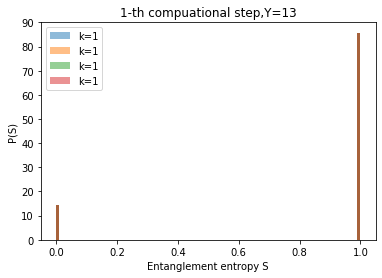

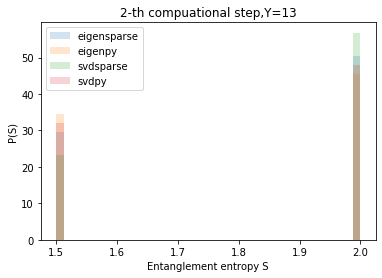

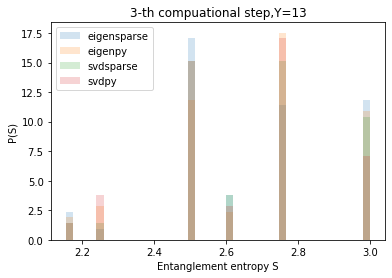

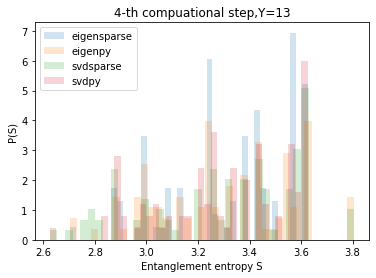

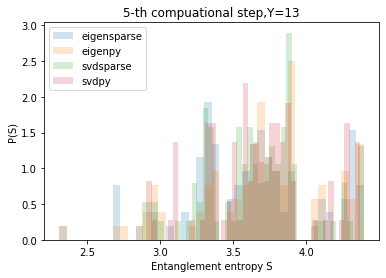

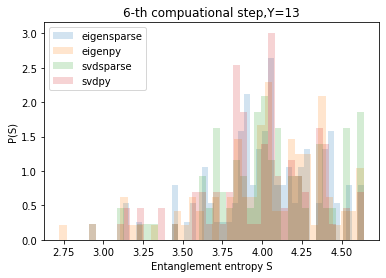

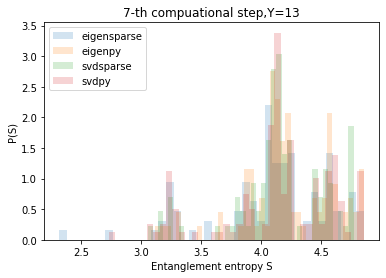

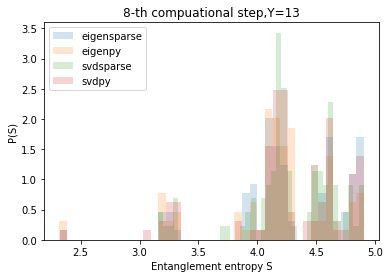

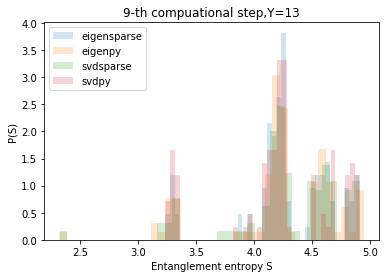

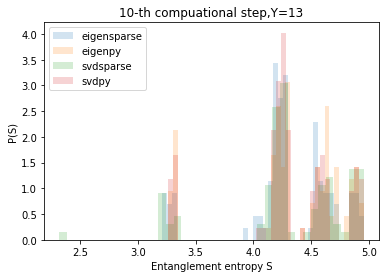

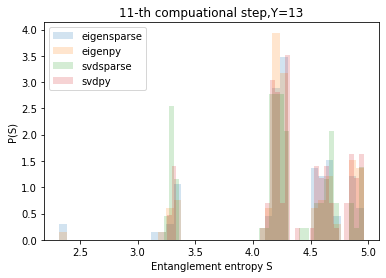

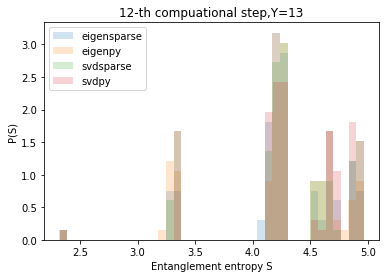

In [7]:
pyplot.hist(eigensparse[0][1], bins=100, alpha=0.5, label='k='+str(1),density=True)
pyplot.hist(eigenpy[0][1], bins=100, alpha=0.5, label='k='+str(1),density=True)
pyplot.hist(svdsparse[0][1], bins=100, alpha=0.5, label='k='+str(1),density=True)
pyplot.hist(svdpy[0][1], bins=100, alpha=0.5, label='k='+str(1),density=True)
pyplot.legend(loc='upper left')
pyplot.xlabel("Entanglement entropy S")
pyplot.ylabel("P(S)")
pyplot.title(str(1)+"-th compuational step,Y="+str(Y))
#pyplot.axvline(x=1,linestyle='--')
#pyplot.savefig("evolution, N=15, Y="+str(j+2)+", k=1.png",dpi=300)
#plt.clf()
pyplot.show()

for i in range(1,2*L):
    pyplot.hist(eigensparse[i][1], bins=40,alpha=0.2, label='eigensparse',density=True)
    pyplot.hist(eigenpy[i][1], bins=40,alpha=0.2, label='eigenpy',density=True)
    pyplot.hist(svdsparse[i][1], bins=40,alpha=0.2, label='svdsparse',density=True)
    pyplot.hist(svdpy[i][1], bins=40,alpha=0.2, label='svdpy',density=True)
    pyplot.legend(loc='upper left')
    pyplot.xlabel("Entanglement entropy S")
    pyplot.ylabel("P(S)")
    pyplot.title(str(i+1)+"-th compuational step,Y="+str(Y))
    #pyplot.savefig("evolution, N=15, Y="+str(j+2)+", k="+str(i+1)+".png",dpi=300)
    #plt.clf()
    pyplot.show()


In [ ]:
#eigenpy=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=True)
#eigensparse=entanglement_entropy_forall_k(Y,N,50,sparse=True,eigen=True)
#svdpy=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=False)
#svdsparse=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=False)
for k in range(2*L):
    fig = plt.figure()
    ax = plt.subplot(111)

    plt.title("different methods of getting entropy")

    ax.plot(range(len(eigenpy[k][1])),[i for i in eigenpy[k][1]],label="eigenumpy",linewidth=0.4)
    ax.plot(range(len(eigensparse[k][1])),[i for i in eigensparse[k][1]],label="eigensparse",linewidth=0.4)
    ax.plot(range(len(svdpy[k][1])),[i for i in svdpy[k][1]],label="svdnumpy",linewidth=0.4)
    ax.plot(range(len(svdsparse[k][1])),[i for i in svdsparse[k][1]],label="eigensparse",linewidth=0.4)
    
    ax.legend()

In [ ]:
#eigenpy=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=True)
#eigensparse=entanglement_entropy_forall_k(Y,N,50,sparse=True,eigen=True)
#svdpy=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=False)
#svdsparse=entanglement_entropy_forall_k(Y,N,50,sparse=False,eigen=False)
for k in range(2*L):
    fig = plt.figure()
    ax = plt.subplot(111)

    plt.title("average with different methods of getting entropy")

    ax.scatter(1,np.mean([i for i in eigenpy[k][1]]),label="eigenumpy")
    ax.scatter(1.1,np.mean([i for i in eigensparse[k][1]]),label="eigensparse")
    ax.scatter(1.2,np.mean([i for i in svdpy[k][1]]),label="svdnumpy")
    ax.scatter(1.3,np.mean([i for i in svdsparse[k][1]]),label="eigensparse")
    
    ax.legend()

In [ ]:
'''montecarlo check'''
import pickle
with open("heatmap.txt", "rb") as fp:
    newdata = pickle.load(fp)
    
N_axis=np.array([x[0] for j in range(len(newdata)) for x in newdata[j]])
Y_axis=np.array([x[1] for j in range(len(newdata)) for x in newdata[j]])
S_axis=np.array([x[2] for j in range(len(newdata)) for x in newdata[j]])

In [ ]:
Y_21=Y_axis[7:17]
print(Y_21[6])
S_21=S_axis[7:17]
print(S_21[6])

-Seen if ur entropy gives same result of heatmap

-See if u can speedup the code for constructing W (not important for N>32)

-See if u can speedup SVD

-At the beginning u can avoid computing the whole nonzero if u reach end of period

1)Introducing QFT in the state

2)look at monogamy of entanglement

3)look at eigenvalues distribution of reduced matrix:

    select only the greatest x=iN (i in [0,1]) singular values and look at the plot
    S_calculated_using_x_singular values(i). See if u can cut many singular values for a fixed N.
    Do this for different N to see if/how the curve growth depend on N
    
    3b)In case 3) goes very well, bottleneck will be W construction. So look at it.

4)Look at histogram of average entropy of all bipartitions to see how it is and try to fit with stuff

5)introduce a further convergence criterion. To be discussed after 4

-Hayashi for geometric/info theory approach